In [16]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [17]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug


In [2]:
# TODO: Import any packages that you might need
import pandas as pd
import matplotlib as mlt
from sagemaker.pytorch import PyTorch
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3


##Dataset

TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-02-19 11:43:55--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.104
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  45.6MB/s    in 25s     

2023-02-19 11:44:30 (42.4 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

##Hyperparameter Tuning

TODO: This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

Note: You will need to use the hpo.py script to perform hyperparameter tuning.

In [14]:
! pip install -qU sagemaker

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
docker-compose 1.29.2 requires PyYAML<6,>=3.10, but you have pyyaml 6.0 which is incompatible.
awscli 1.27.24 requires botocore==1.29.24, but you have botocore 1.29.74 which is incompatible.
awscli 1.27.24 requires PyYAML<5.5,>=3.10, but you have pyyaml 6.0 which is incompatible.
awscli 1.27.24 requires rsa<4.8,>=3.1.2, but you have rsa 4.9 which is incompatible.
aiobotocore 2.4.1 requires botocore<1.27.60,>=1.27.59, but you have botocore 1.29.74 which is incompatible.


In [15]:
!pip install torch

  Using cached torch-1.13.1-cp37-cp37m-manylinux1_x86_64.whl (887.5 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)


In [10]:
prefix ="dogImagesDataset"
print("Starting to uploading dogImages")

inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print(f"Input path ( S3 file path ): {inputs}")

Starting to uploading dogImages
Input path ( S3 file path ): s3://sagemaker-us-east-1-738366941061/dogImagesDataset


In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
# Initializing some useful variables
region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))
print(f"Default s3 bucket : {bucket}")
##Reference: https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-train-model.html

AWS Region: us-east-1
RoleArn: arn:aws:iam::738366941061:role/service-role/AmazonSageMaker-ExecutionRole-20230214T161026
Default s3 bucket : sagemaker-us-east-1-738366941061


In [3]:
#Importing all the required modules fomr tuner
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)


hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 32,64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [4]:
from  sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "hpo1.py",
    base_job_name = "dog-breed-classification-hpo",
    role = role,
    instance_count = 1,
    instance_type = "ml.m5.2xlarge",
    py_version = "py36",
    framework_version = "1.8"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

#Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

Note: You will need to use the train_model.py script to perform model profiling and debugging

In [5]:
#adding here only for rerun purposes ( to avoid uploading the inputs again)
input_data = 's3://sagemaker-us-east-1-738366941061/dogImagesDataset'
print(f"Input path ( S3 file path ): {input_data}")

Input path ( S3 file path ): s3://sagemaker-us-east-1-738366941061/dogImagesDataset


In [6]:
tuner.fit({"training": input_data }, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [8]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-02-20 12:41:23 Starting - Found matching resource for reuse
2023-02-20 12:41:23 Downloading - Downloading input data
2023-02-20 12:41:23 Training - Training image download completed. Training in progress.
2023-02-20 12:41:23 Uploading - Uploading generated training model
2023-02-20 12:41:23 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'eps': '3.91625725247745e-09',
 'lr': '0.0005258820459279914',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2023-02-20-11-55-31-833"',
 'sagemaker_program': '"hpo1.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-738366941061/dog-breed-classification-hpo-2023-02-20-11-55-31-833/source/sourcedir.tar.gz"',
 'weight_decay': '0.001161805186085378'}

##Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

Note: You will need to use the train_model.py script to perform model profiling and debugging.

In [10]:
# Create and fit an estimator
from  sagemaker.pytorch import PyTorch
hyperparameters = {"batch_size": "32", "lr": "0.0005258820459279914"} # Training with best parameters
estimator = PyTorch(
    entry_point="train_model1.py",
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    role=role,
    py_version="py36",
    framework_version="1.6", #using 1.6 as it has support for smdebug lib , https://github.com/awslabs/sagemaker-debugger#debugger-supported-frameworks
    hyperparameters=hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

estimator.fit({'train' : input_data },wait=True)

2023-02-20 12:42:55 Starting - Starting the training job...
2023-02-20 12:43:22 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-02-20 12:44:23 Downloading - Downloading input data...
2023-02-20 12:44:56 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-20 12:45:08,462 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-20 12:45:08,464 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-20 12:45:08,475 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-20 12:45:08,478 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-20 12:45:08,650 sagema

In [ ]:
# TODO: Plot a debugging output.

In [13]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
#creating a trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-02-20 13:09:11.426 datascience-1-0-ml-m5-2xlarge-edc54522b6c2075d0551eb4e13d2:32 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-02-20 13:09:11.437 datascience-1-0-ml-m5-2xlarge-edc54522b6c2075d0551eb4e13d2:32 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-738366941061/pytorch-training-2023-02-20-12-42-55-364/debug-output


##Model Deploying

In [12]:
!pip install smdebug

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [15]:
#Defining some utility functions to be used for plotting tensors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()
##Reference :https://github.com/aws/amazon-sagemaker-examples/blob/main//sagemaker-debugger/pytorch_model_debugging/pytorch_script_change_smdebug.ipynb

[2023-02-20 13:10:56.387 datascience-1-0-ml-m5-2xlarge-edc54522b6c2075d0551eb4e13d2:32 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-02-20 13:10:57.404 datascience-1-0-ml-m5-2xlarge-edc54522b6c2075d0551eb4e13d2:32 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


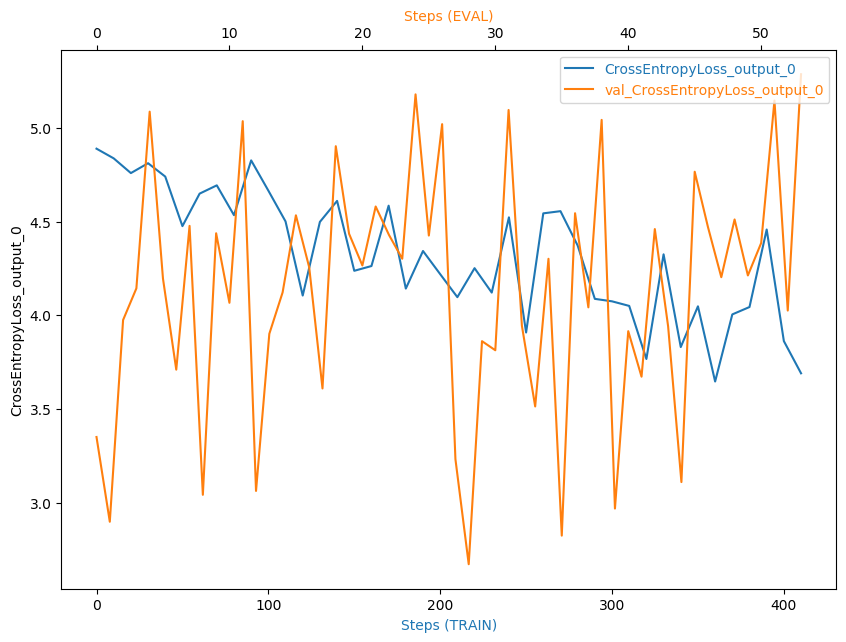

In [16]:
#plotting the tensor
plot_tensor(trial, "CrossEntropyLoss_output_0")

TODO: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?
TODO: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [17]:
# TODO: Display the profiler output
##Reference: https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-train-model.html
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-738366941061/pytorch-training-2023-02-20-12-42-55-364/rule-output


In [18]:
! aws s3 ls {rule_output_path} --recursive
##Reference:https://github.com/aws/amazon-sagemaker-examples/blob/main//sagemaker-debugger/pytorch_model_debugging/pytorch_script_change_smdebug.ipynb


2023-02-20 13:05:12     374906 pytorch-training-2023-02-20-12-42-55-364/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-02-20 13:05:11     222823 pytorch-training-2023-02-20-12-42-55-364/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-02-20 13:05:06        192 pytorch-training-2023-02-20-12-42-55-364/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-02-20 13:05:06        200 pytorch-training-2023-02-20-12-42-55-364/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-02-20 13:05:06       1949 pytorch-training-2023-02-20-12-42-55-364/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-02-20 13:05:06        127 pytorch-training-2023-02-20-12-42-55-364/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-02-20 13:05:06        199 pytorch-training-2023-02-20-12-42-55-364/rule-output/ProfilerReport/profiler-output/profiler-re

In [19]:
! aws s3 cp {rule_output_path} ./ --recursive
##Reference:https://github.com/aws/amazon-sagemaker-examples/blob/main//sagemaker-debugger/pytorch_model_debugging/pytorch_script_change_smdebug.ipynb


download: s3://sagemaker-us-east-1-738366941061/pytorch-training-2023-02-20-12-42-55-364/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-738366941061/pytorch-training-2023-02-20-12-42-55-364/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-738366941061/pytorch-training-2023-02-20-12-42-55-364/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-738366941061/pytorch-training-2023-02-20-12-42-55-364/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-73836694106

In [20]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
##Reference :https://github.com/aws/amazon-sagemaker-examples/blob/main//sagemaker-debugger/pytorch_model_debugging/pytorch_script_change_smdebug.ipynb

In [21]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")
##Reference :https://github.com/aws/amazon-sagemaker-examples/blob/main//sagemaker-debugger/pytorch_model_debugging/pytorch_script_change_smdebug.ipynb

In [75]:
# loading the model manually from its location in S3
model_location = estimator.model_data


In [76]:
model_location

's3://sagemaker-us-east-1-738366941061/pytorch-training-2023-02-20-12-42-55-364/output/model.tar.gz'

In [82]:
#import neccessary libraries
from PIL import Image
import io
import os
import numpy as np
import sagemaker
import boto3
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [83]:
#creating a class

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class PredictingImage(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( PredictingImage, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer)
        

In [84]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='endpoint.py', py_version='py3',
                             framework_version='1.6',
                             predictor_cls=PredictingImage)

In [85]:
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='endpoint.py', py_version='py3',
                             framework_version='1.6',
                             predictor_cls=PredictingImage)

In [88]:
from sagemaker.predictor import Predictor
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.2xlarge')


----!

In [97]:
# TODO: Run an prediction on the endpoint
with open ("dogImages/test/048.Chihuahua/Chihuahua_03427.jpg" , 'rb') as f :
    image = f.read()
type(image)

bytes

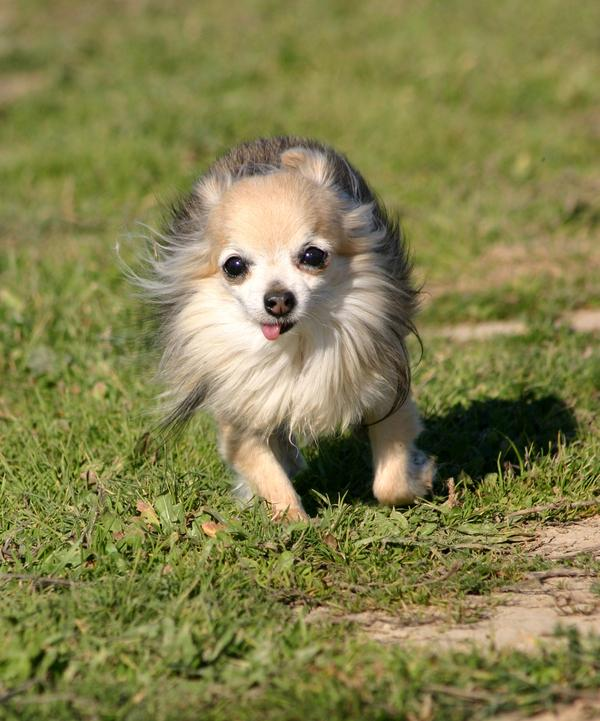

In [98]:
# TODO: Run an prediction on the endpoint

from PIL import Image
import io
Image.open(io.BytesIO(image))
